In [1]:
import torch
from codes.model import  ResUnet_LSTM_L, Loss_With_Weight
from torch.utils.data import DataLoader
from codes.dataloader import init_dataset, STEAD_Dataset
from codes import configs
from codes.visualize_and_evaluate import showRawWave,showWave,showProb

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

train_set,val_set,noise_set = init_dataset()
train_set = STEAD_Dataset(train_set)
val_set = STEAD_Dataset(val_set)

eval_dataloader = DataLoader(val_set, shuffle=True,batch_size=1, num_workers=0, drop_last=True)

C:\Users\29147\.conda\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


total events in csv file: 1265657
total events selected: 376492


C:\Users\29147\.conda\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,11,13,14,15,18,19,20,21,22,24,25,26,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


total noise selected: 235426


In [ ]:
from codes.model import  ResUnet_LSTM_L
model = ResUnet_LSTM_L(False)
model.load_state_dict(torch.load("./result/models/std_norm_iter14061.pt"))
model.eval().to(device)

In [3]:
iter = enumerate(eval_dataloader,0)

C:\Users\29147\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


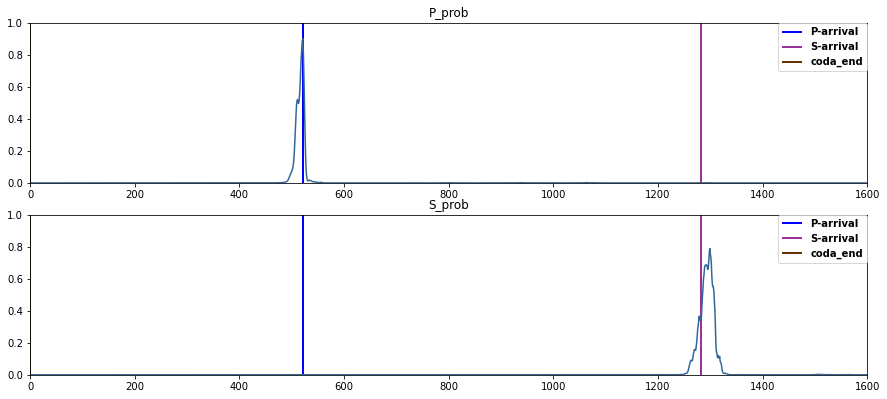

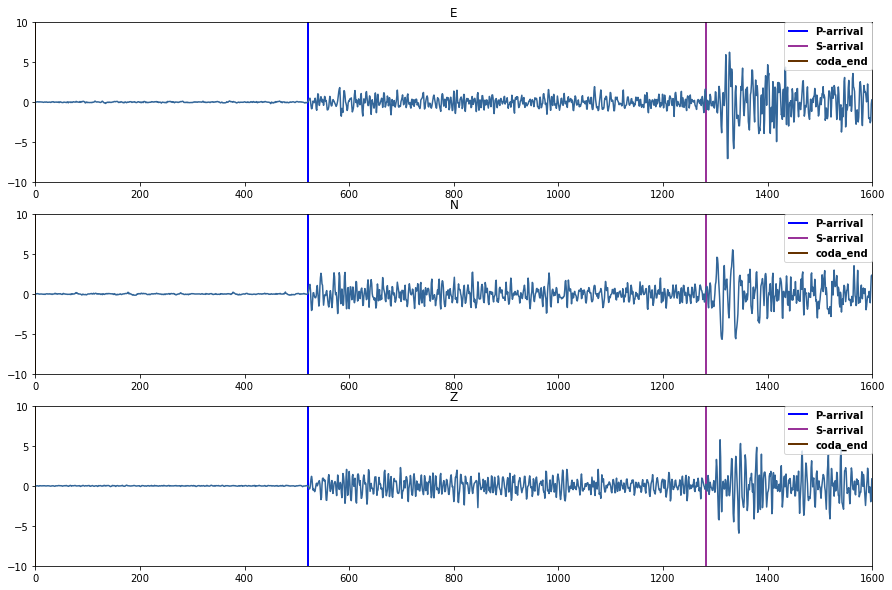

In [13]:
index,data = iter.__next__()
stream,label_p,label_s,p_start,s_start,coda_end = data
output = model(stream.to(device))
showProb(output.detach().cpu()[0],p_start[0],s_start[0],coda_end[0])
showRawWave(stream.detach().cpu()[0],p_start[0],s_start[0],coda_end[0])

## make gif

In [51]:
stream_2 = torch.zeros(1,3,1600)
stream_3 = torch.cat((stream_2,stream,stream_2),dim=2)
i=0
p_time = 1600
s_time = 1600

C:\Users\29147\.conda\envs\pytorch\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


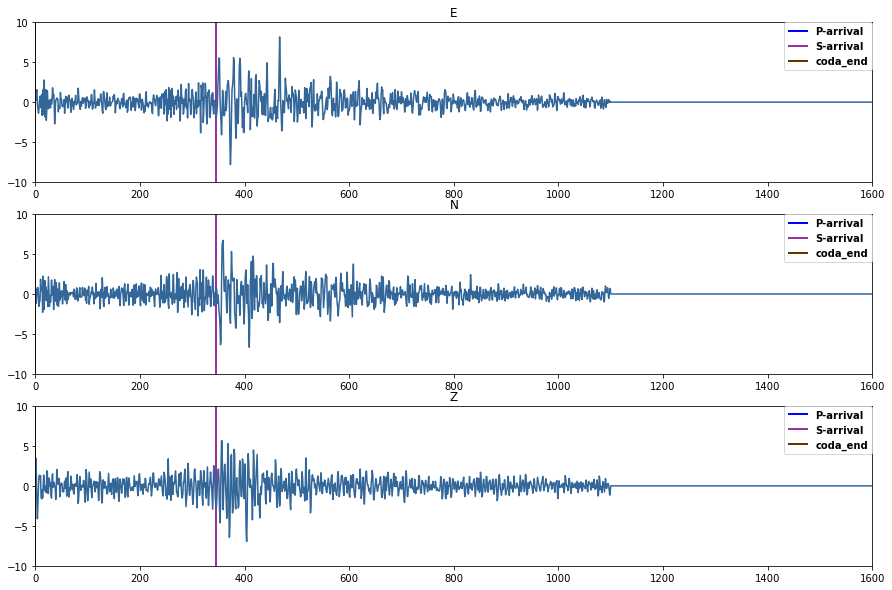

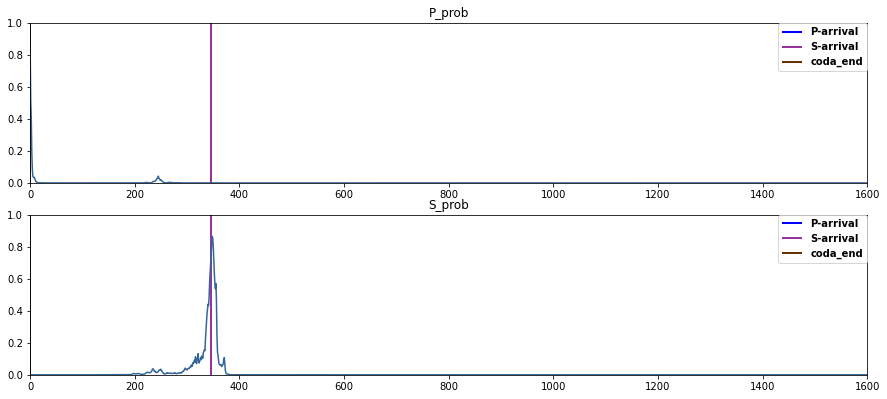

In [94]:

output = model(stream_3.to(device))

if p_start[0]+1600-i*50 < 1600:
    p_time = p_start[0]+1600-i*50
if s_start[0]+1600-i*50 < 1600:
    s_time = s_start[0]+1600-i*50

showRawWave(stream_3[:,:,i*50:i*50+1600].detach().cpu()[0],p_time,s_time,coda_end[0],"C:/Users/29147/Desktop/gif/gif1/wave/wave_{}".format(i))
showProb(output[:,:,i*50:i*50+1600].detach().cpu()[0],p_time,s_time,coda_end[0],"C:/Users/29147/Desktop/gif/gif1/prob/prob_{}".format(i))
i+=1


In [1]:
import onnx

with torch.no_grad(): 
    torch.onnx.export( 
        model,                              # 模型对象
        torch.randn(1, 3, 1600),                                  # 与input同形状的数据
        configs.result_dir+"models/onnx_model.onnx",                       # 文件名
        opset_version=11,                   # opset_version 表示 ONNX 算子集的版本
        input_names=['input'], 
        output_names=['output'])